In [1]:
import numpy as np
import random as ran
import pandas as pd

#For plotting
%pylab inline
import matplotlib.pyplot as plt

#For computing time
from datetime import datetime

#For model and their corresponding
from torch.autograd import Variable
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T

#For confusion matrix, precision, recall,  f1-score
from sklearn import metrics as mat
import seaborn as sn
import itertools

#For modeldetail
from torchsummary import summary

Populating the interactive namespace from numpy and matplotlib


# GPU Availability

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No cuda available")
print(f"Used device is {device}")

Used device is cuda:0


# Import dataset and Data Loader

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=T.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=T.ToTensor())
train_dl = torch.utils.data.DataLoader(mnist_trainset, batch_size = 100, shuffle=True, num_workers=2)
test_dl = torch.utils.data.DataLoader(mnist_testset, batch_size = 100, shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Summary of data

In [4]:
print(f"Train set size : {mnist_trainset.data.size()}")
print(f"Test set size : {mnist_testset.data.size()}")
print(f"The number of classes : {len(mnist_testset.classes)}")
print(f"Train data set : {mnist_trainset}")
print(f"Test data set : {mnist_testset}")

Train set size : torch.Size([60000, 28, 28])
Test set size : torch.Size([10000, 28, 28])
The number of classes : 10
Train data set : Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Test data set : Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


# Print one train data

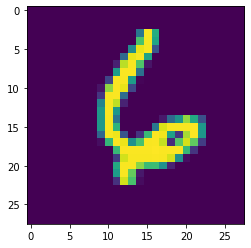

In [5]:
plt.imshow(mnist_trainset.data[59000])
plt.show()

# Print multiple train data

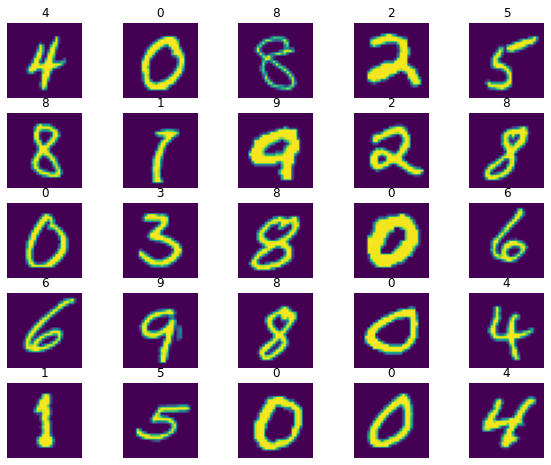

In [6]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_trainset), size=(1,)).item()
    img, label = mnist_trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

## Create Model

Class Model

In [7]:
class MODEL(nn.Module):
  def __init__(self):
      super(MODEL, self).__init__()
      self.Model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding = 2, bias = True),       
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.Dropout(p = 0.2),
        nn.MaxPool2d(2, stride = 2),

        nn.Conv2d(6, 16, 5),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(p = 0.2),
        nn.MaxPool2d(2, stride = 2),
        
        nn.Flatten(),
        nn.Linear(400, 100),
        nn.ReLU(),
        nn.Linear(100, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
      )

  def forward(self, x):
      return self.Model(x)

model = MODEL()
print(model)

MODEL(
  (Model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=400, out_features=100, bias=True)
    (12): ReLU()
    (13): Linear(in_features=100, out_features=84, bias=True)
    (14): ReLU()
    (15): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [8]:
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [9]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
       BatchNorm2d-2            [-1, 6, 28, 28]              12
              ReLU-3            [-1, 6, 28, 28]               0
           Dropout-4            [-1, 6, 28, 28]               0
         MaxPool2d-5            [-1, 6, 14, 14]               0
            Conv2d-6           [-1, 16, 10, 10]           2,416
       BatchNorm2d-7           [-1, 16, 10, 10]              32
              ReLU-8           [-1, 16, 10, 10]               0
           Dropout-9           [-1, 16, 10, 10]               0
        MaxPool2d-10             [-1, 16, 5, 5]               0
          Flatten-11                  [-1, 400]               0
           Linear-12                  [-1, 100]          40,100
             ReLU-13                  [-1, 100]               0
           Linear-14                   

# Training

In [10]:
train_accuracy = []
train_loss = []
def train(epoch):
  print(f'Epoch : {epoch}')
  model.train()

  running_loss = 0
  correct = 0
  total = 0

  for i, (images, labels) in enumerate(train_dl):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    pred = model(images)
    loss = loss_function(pred, labels)
    if i % 100 == 99:
        print(f"Training looss in {i + 1}th step is {loss.item()}")
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = pred.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  training_loss = running_loss / len (train_dl)
  accuracy = 100 * correct / total

  train_accuracy.append(accuracy)
  train_loss.append(training_loss)

  print('Train Loss: %.3f | Accuracy: %.3f'%(training_loss, accuracy)) 

## Testing

In [11]:
test_accuracy = []
test_loss = []
label = []  #For confusion matrix
prediction = []  #For confusion matrix

def test(epoch):
  print(f'Epoch : {epoch}')
  model.eval()

  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for i, (images, labels) in enumerate(test_dl):
      images = images.to(device)
      labels = labels.to(device)
      pred = model(images)

      if epoch == epochs:
          label.append(labels) 
          prediction.append(pred)

      loss = loss_function(pred, labels)
      if i % 100 == 99:
        print(f"Testing loss in {i + 1}th step is {loss.item()}")
      running_loss += loss.item()

      _, predicted = pred.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

  testing_loss = running_loss / len (test_dl)
  accuracy = 100 * correct / total

  test_accuracy.append(accuracy)
  test_loss.append(testing_loss)

  print('Test Loss: %.3f | Accuracy: %.3f'%(testing_loss, accuracy)) 

In [12]:
epochs=10
start = datetime.now()
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)
end = datetime.now()
print(f"Total required time is {end - start}")

Epoch : 1
Training looss in 100th step is 0.29448023438453674
Training looss in 200th step is 0.10900452733039856
Training looss in 300th step is 0.060016632080078125
Training looss in 400th step is 0.03365030512213707
Training looss in 500th step is 0.15731707215309143
Training looss in 600th step is 0.07705891877412796
Train Loss: 0.208 | Accuracy: 93.872
Epoch : 1
Testing loss in 100th step is 0.07589460164308548
Test Loss: 0.076 | Accuracy: 98.040
Epoch : 2
Training looss in 100th step is 0.05147145688533783
Training looss in 200th step is 0.07710030674934387
Training looss in 300th step is 0.036567434668540955
Training looss in 400th step is 0.020635252818465233
Training looss in 500th step is 0.11861944943666458
Training looss in 600th step is 0.047069016844034195
Train Loss: 0.070 | Accuracy: 97.803
Epoch : 2
Testing loss in 100th step is 0.06361021846532822
Test Loss: 0.052 | Accuracy: 98.600
Epoch : 3
Training looss in 100th step is 0.008313748985528946
Training looss in 200th

In [13]:
print(f"Final test accuracy is {test_accuracy[-1]}")

Final test accuracy is 98.98


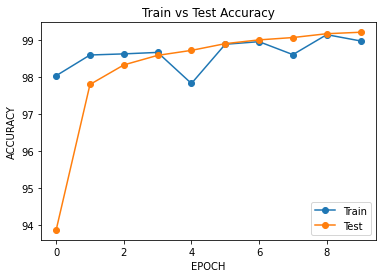

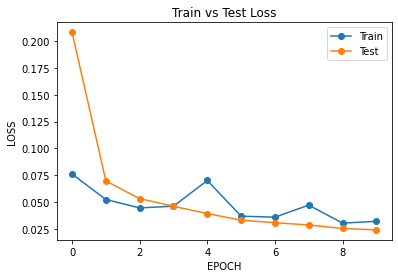

In [14]:
plt.plot(test_accuracy,'-o')
plt.plot(train_accuracy,'-o')
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
plt.show()

plt.plot(test_loss,'-o')
plt.plot(train_loss,'-o')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend(['Train','Test'])
plt.title('Train vs Test Loss')
plt.show()

## Making Report

In [15]:
Data = pd.DataFrame({'Train Accuracy' : train_accuracy, 'Test Accuracy': test_accuracy, 'Train loss' : train_loss, 
                     'test_loss': test_loss},  index=[ 'epoch ' + str(i+1) for i in range(epochs)])
print(Data)
Data.to_csv("Report.csv")
with open('Report.txt', 'w') as f:
  f.write("Test Accuracy is "+ str(test_accuracy[-1]))
  f.write("\n")
  f.write("Test Loss is "+ str(test_loss[-1]))

          Train Accuracy  Test Accuracy  Train loss  test_loss
epoch 1        93.871667          98.04    0.208253   0.076167
epoch 2        97.803333          98.60    0.069732   0.052411
epoch 3        98.331667          98.63    0.053215   0.044561
epoch 4        98.590000          98.67    0.046101   0.046222
epoch 5        98.725000          97.83    0.039333   0.070129
epoch 6        98.906667          98.89    0.033150   0.036918
epoch 7        99.008333          98.96    0.030824   0.035959
epoch 8        99.071667          98.61    0.028678   0.047191
epoch 9        99.175000          99.15    0.025431   0.030415
epoch 10       99.215000          98.98    0.024085   0.032090


## Confusion Matrix

Making true_label in numpy array

In [16]:
true_label = []
for i in label:
  true_label.append(i.cpu().detach().numpy())
true_label = np.array(true_label).reshape(len(mnist_testset))

Making pred_label in numpy array and then make predicted lavel

In [17]:
pred_label = []
for i in prediction:
  pred_label.append(i.cpu().detach().numpy())
pred_label = np.array(pred_label)
predict_label = []
for j in range(len(test_dl)):
  for i in range(len(test_dl)):
    predict_label.append(np.argmax(np.round(pred_label[j][i])))
predict_label = np.array(predict_label)

Function for confusion matrix

In [18]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.magma):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")
    plt.tight_layout()
    plt.ylabel('TRUE LABEL')
    plt.xlabel('Predicted LABEL')
    plt.show()

Plot the confusion matrix

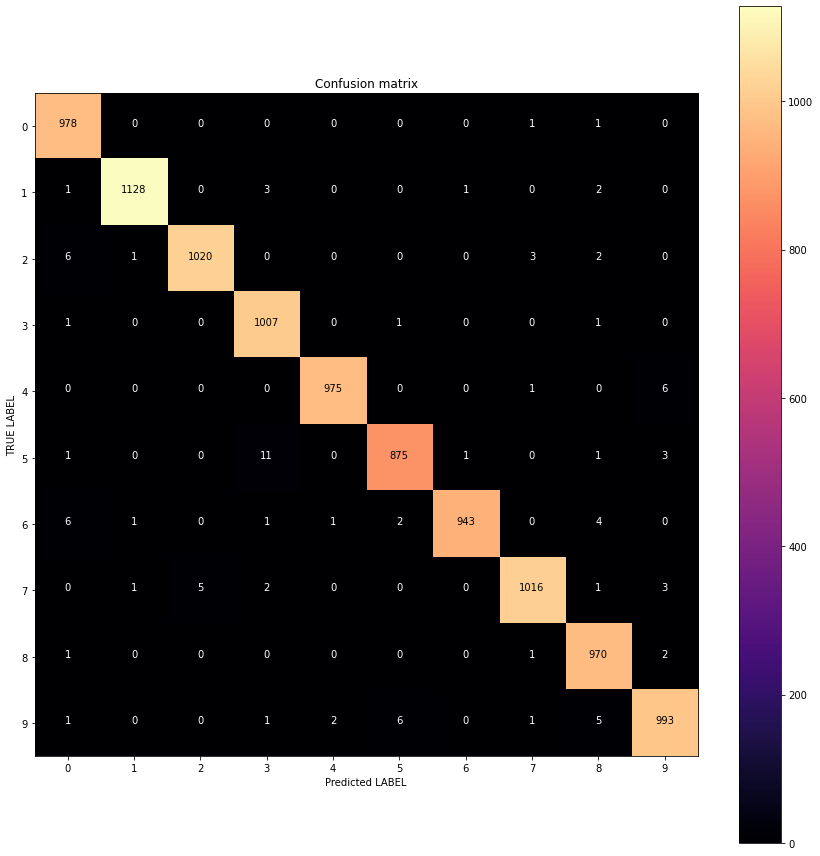

In [19]:
cm = mat.confusion_matrix(true_label,predict_label)
cm_plot = plot_confusion_matrix(cm,classes=[i for i in range(10)])

## Performance Report

In [21]:
target=[str(i) for i in range(len(mnist_testset.classes))]
print('Classification Report'.center(65,' '),'\n', mat.classification_report(true_label,predict_label,target_names=target))

                      Classification Report                       
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      1.00      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Prediction of some data taken from test set

In [22]:
examples = enumerate(test_dl)
batch_idx, (example_data, example_targets) = next(examples)
example_data_tensor = example_data.to(device)
example_targets_tensor = example_targets.to(device)

In [23]:
with torch.no_grad():
  output = model(example_data_tensor)

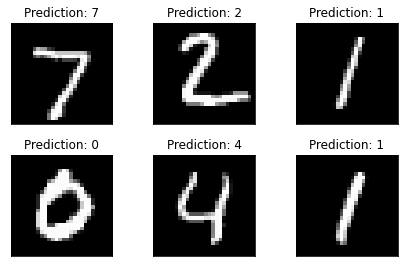

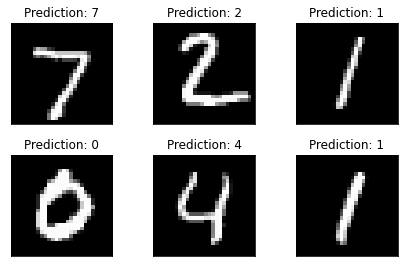

In [24]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig